In [ ]:
!unzip /content/0753aae4bec411eb.zip

Archive:  /content/0753aae4bec411eb.zip
  inflating: sample submission.csv   
  inflating: Test.csv                
  inflating: Train.csv               


In [ ]:
import pandas as pd
train_data = pd.read_csv("/content/Train.csv")

test_data =  pd.read_csv("/content/Test.csv")


In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,15
import seaborn as sns
import os
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm ,tnrange

from catboost import CatBoostRegressor

Some Helper Functions From various Kaggle Kernels

In [ ]:
def nullColumns(train_data):
    list_of_nullcolumns =[]
    for column in train_data.columns: 
        total= train_data[column].isna().sum()
        try:
            if total !=0:
                print('Total Na values is {0} for column {1}' .format(total, column))
                list_of_nullcolumns.append(column)
        except: 
            print(column,"-----",total)
    print('\n')
    return list_of_nullcolumns


def percentMissingFeature(data):
    data_na = (data.isnull().sum() / len(data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    return data_na


def plotMissingFeature(data_na):
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    if(data_na.empty ==False):
        sns.barplot(x=data_na.index, y=data_na)
        plt.xlabel('Features', fontsize=15)
        plt.ylabel('Percent of missing values', fontsize=15)
        plt.title('Percent missing data by feature', fontsize=15)

In [ ]:
def feature_importance(model, X_train):
    fI = model.feature_importances_
    print(fI)
    names = X_train.columns.values
    ticks = [i for i in range(len(names))]
    plt.bar(ticks, fI)
    plt.xticks(ticks, names,rotation = 90)
    plt.show()

In [ ]:
print('train data')
print(nullColumns(train_data))
print(percentMissingFeature(train_data))
print('\n')
print('test_data')
print(nullColumns(test_data))
print(percentMissingFeature(test_data))

train data
Total Na values is 3336 for column BiasInfluentialFactor


['BiasInfluentialFactor']
BiasInfluentialFactor    24.448516
dtype: float64


test_data


[]
Series([], dtype: float64)


We'll Predict the 3336 values using a LightGBM Classifier

In [ ]:
test_data = train_data.loc[train_data.BiasInfluentialFactor.isnull()]


In [ ]:
train_data = train_data.loc[train_data.BiasInfluentialFactor.notnull()]


Dropping EmpID&Emp Name from the feature Lists

In [ ]:
train_data.drop(columns = ['EmpID','EmpName'],inplace = True)
test_data.drop(columns = ['EmpID','EmpName'],inplace = True)

Specifying caagorical and continuous features for cummulative  label encoding

In [ ]:
cat_features = ['LanguageOfCommunication','Gender', 'JobProfileIDApplyingFor','GraduationYear','HighestDegree', 'DegreeBranch', 'GraduatingInstitute','MartialStatus','CurrentDesignation','CurrentCompanyType','DepartmentInCompany']

cont_features = []

label = 'FitmentPercent'

In [ ]:
def encode_cat_cols(train, test, cat_cols): #target
    train_df = train_data.copy()
    test_df = test_data.copy()
    # Making a dictionary to store all the labelencoders for categroical columns to transform them later.
    le_dict = {}

    for col in cat_cols:
          le = LabelEncoder()
          le.fit(train_df[col].unique().tolist() + test_df[col].unique().tolist())
          train_df[col] = le.transform(train_df[[col]])
          test_df[col] = le.transform(test_df[[col]])
          le_dict[col] = le
#     train_df['Vehicle_Age'] = train_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})
#     test_df['Vehicle_Age'] = test_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})
    # le = LabelEncoder()
    # train_df[label] = le.fit_transform(train_df[[label]])
    # le_dict[label] = le
    return train_df, test_df, le_dict

***see the name of the actual test set is "test_dff"***


*we'll use the trained model for predicting the values for actual test*

In [ ]:

train_df, test_dff, le_dict = encode_cat_cols(train_data,test_data,cat_features)

In [ ]:
train_df.head()

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken,BiasInfluentialFactor,FitmentPercent
0,0,35,1,3,0,2,0,7,12,0,21,26,0,5,7,0,1,20,YearsOfExperince,95.40
2,0,36,0,4,7,1,0,6,6,6,15,24,1,5,5,1,2,19,Gender,91.26
3,0,29,0,4,1,5,1,5,6,6,16,24,0,5,5,2,4,16,Gender,72.29
4,0,25,1,0,2,1,2,8,2,10,24,32,0,5,5,0,2,10,DegreeBranch,86.34
5,2,35,1,7,1,1,1,9,12,0,25,29,0,4,3,1,2,10,YearsOfExperince,93.23


DIfferent Set of Discretizations were done.

In [ ]:
# gpa_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
# train_df['LatestDegreeCGPA'] =gpa_discretizer.fit_transform(train_df['LatestDegreeCGPA'].values.reshape(-1,1)).astype(int)
# age_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
# train_df['Age'] =age_discretizer.fit_transform(train_df['Age'].values.reshape(-1,1)).astype(int)
# yoe_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
# train_df['YearsOfExperince'] =yoe_discretizer.fit_transform(train_df['YearsOfExperince'].values.reshape(-1,1)).astype(int)
# CTC_discretizer = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='quantile')
# train_df['CurrentCTC'] =CTC_discretizer.fit_transform(train_df['CurrentCTC'].values.reshape(-1,1)).astype(int)
# ECTC_discretizer = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='quantile')
# train_df['ExpectedCTC'] =ECTC_discretizer.fit_transform(train_df['ExpectedCTC'].values.reshape(-1,1)).astype(int)
# Leaves_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
# train_df['TotalLeavesTaken'] =Leaves_discretizer.fit_transform(train_df['TotalLeavesTaken'].values.reshape(-1,1)).astype(int)
# GYdiscretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
# train_df['GraduationYear'] =GYdiscretizer.fit_transform(train_df['GraduationYear'].values.reshape(-1,1)).astype(int)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
train_df.head()

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken,BiasInfluentialFactor,FitmentPercent
0,0,35,1,3,0,2,0,7,12,0,21,26,0,5,7,0,1,20,YearsOfExperince,95.40
2,0,36,0,4,7,1,0,6,6,6,15,24,1,5,5,1,2,19,Gender,91.26
3,0,29,0,4,1,5,1,5,6,6,16,24,0,5,5,2,4,16,Gender,72.29
4,0,25,1,0,2,1,2,8,2,10,24,32,0,5,5,0,2,10,DegreeBranch,86.34
5,2,35,1,7,1,1,1,9,12,0,25,29,0,4,3,1,2,10,YearsOfExperince,93.23


In [ ]:
le = LabelEncoder()
train_df["BiasInfluentialFactor"] = le.fit_transform(train_df[["BiasInfluentialFactor"]])

In [ ]:
train_df.head()

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken,BiasInfluentialFactor,FitmentPercent
0,0,35,1,3,0,2,0,7,12,0,21,26,0,5,7,0,1,20,8,95.40
2,0,36,0,4,7,1,0,6,6,6,15,24,1,5,5,1,2,19,4,91.26
3,0,29,0,4,1,5,1,5,6,6,16,24,0,5,5,2,4,16,4,72.29
4,0,25,1,0,2,1,2,8,2,10,24,32,0,5,5,0,2,10,1,86.34
5,2,35,1,7,1,1,1,9,12,0,25,29,0,4,3,1,2,10,8,93.23


In [ ]:
target = train_df['BiasInfluentialFactor']


In [ ]:
train_df.head()

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken,BiasInfluentialFactor,FitmentPercent
0,0,35,1,3,0,2,0,7,12,0,21,26,0,5,7,0,1,20,8,95.40
2,0,36,0,4,7,1,0,6,6,6,15,24,1,5,5,1,2,19,4,91.26
3,0,29,0,4,1,5,1,5,6,6,16,24,0,5,5,2,4,16,4,72.29
4,0,25,1,0,2,1,2,8,2,10,24,32,0,5,5,0,2,10,1,86.34
5,2,35,1,7,1,1,1,9,12,0,25,29,0,4,3,1,2,10,8,93.23


In [ ]:
test_size = 0.20



Train:95%
Test: 5%

In [ ]:
train_df, test_df, target, Y_test = train_test_split (train_df.drop(columns=['BiasInfluentialFactor']), train_df['BiasInfluentialFactor'], test_size = 0.05, random_state=42)

In [ ]:
train_df.head()

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken,FitmentPercent
11805,0,33,1,4,2,1,1,4,10,2,27,34,0,4,1,0,2,15,86.66
6732,0,28,2,2,0,5,1,7,5,7,9,17,0,3,4,0,1,11,68.53
5769,0,34,1,3,0,4,0,9,11,1,28,37,0,4,5,0,3,17,91.12
7992,0,24,0,5,1,4,0,8,1,11,11,19,0,4,7,2,2,17,85.89
1791,1,35,1,4,2,1,1,7,12,0,24,31,1,3,5,2,0,17,83.38


In [ ]:
test_df.head()

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken,FitmentPercent
13542,1,31,1,3,0,0,1,10,8,4,20,26,1,3,1,2,2,13,80.36
7692,0,26,1,4,0,1,0,9,3,9,20,25,0,3,0,1,2,6,94.25
431,0,34,1,3,2,5,1,9,11,1,19,28,0,3,7,0,3,9,69.45
11977,1,24,1,3,3,5,1,5,1,11,7,11,1,3,4,2,1,10,79.85
11303,2,31,0,3,4,1,2,7,5,7,25,35,1,3,5,2,1,16,72.78


Storing the fitment foor later use

In [ ]:
fitment_train = train_df.FitmentPercent.values
fitment_test = test_df.FitmentPercent.values

In [ ]:
train_df.drop(columns = ['FitmentPercent'],inplace=True)
test_df.drop(columns = ['FitmentPercent'],inplace=True)

Normaziling the continuous features performed better than binning them in both Classification and regression

In [ ]:
train_df['Age'] = np.log(train_df['Age'])
train_df['CurrentCTC'] = np.log(train_df['CurrentCTC'])
train_df['ExpectedCTC'] = np.log(train_df['ExpectedCTC'])
train_df['TotalLeavesTaken'] = np.log(train_df['TotalLeavesTaken'])
test_df['Age'] = np.log(test_df['Age'])
test_df['CurrentCTC'] = np.log(test_df['CurrentCTC'])
test_df['ExpectedCTC'] = np.log(test_df['ExpectedCTC'])
test_df['TotalLeavesTaken'] = np.log(test_df['TotalLeavesTaken'])


In [ ]:
train_df['YearsOfExperince'] = np.log(train_df['YearsOfExperince'])
test_df['YearsOfExperince'] = np.log(test_df['YearsOfExperince'])



In [ ]:
import tensorflow
import keras
from tensorflow.keras.utils import to_categorical

Using 5F StratifiedShuffleSplit split with LightGBM

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 7834 rows of holdout = 1959
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 0.922623	valid_0's multi_logloss: 0.922623
[200]	valid_0's multi_logloss: 0.59077	valid_0's multi_logloss: 0.59077
[300]	valid_0's multi_logloss: 0.431886	valid_0's multi_logloss: 0.431886
[400]	valid_0's multi_logloss: 0.357374	valid_0's multi_logloss: 0.357374
[500]	valid_0's multi_logloss: 0.31574	valid_0's multi_logloss: 0.31574
[600]	valid_0's multi_logloss: 0.292061	valid_0's multi_logloss: 0.292061
[700]	valid_0's multi_logloss: 0.277654	valid_0's multi_logloss: 0.277654
[800]	valid_0's multi_logloss: 0.268368	valid_0's multi_logloss: 0.268368
[900]	valid_0's multi_logloss: 0.262275	valid_0's multi_logloss: 0.262275
[1000]	valid_0's multi_logloss: 0.258445	valid_0's multi_logloss: 0.258445
[1100]	valid_0's multi_logloss: 0.2561

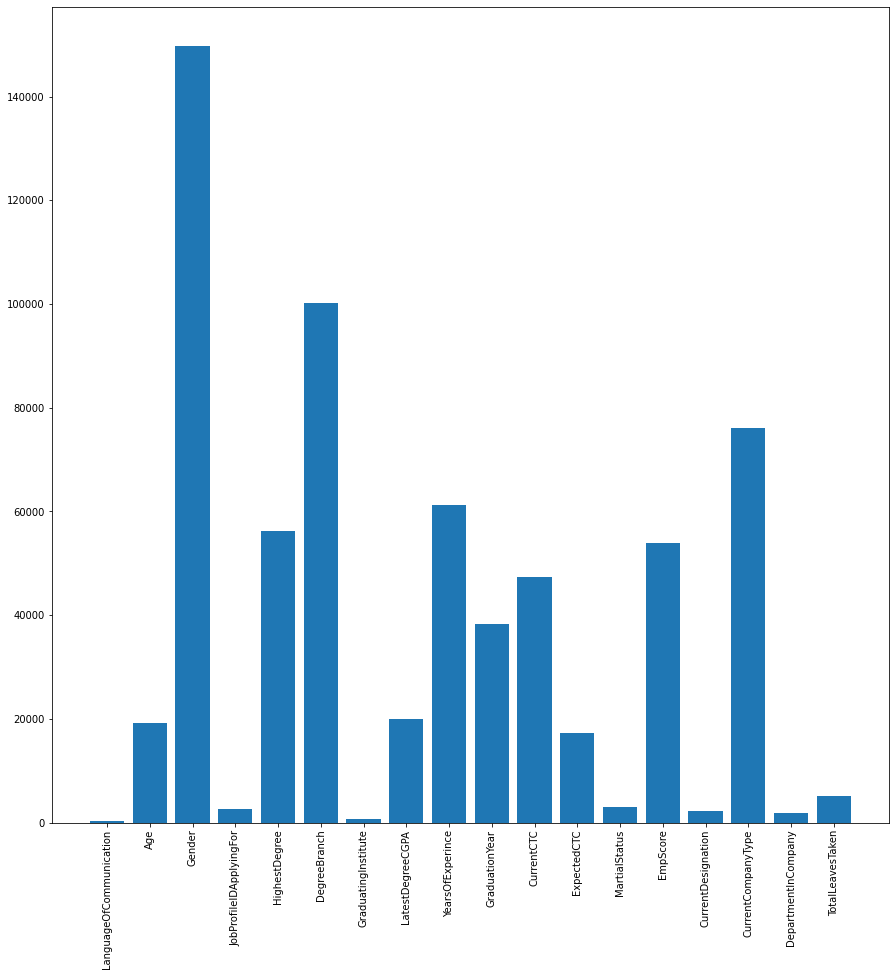

Fold 1
 rows of train = 7834 rows of holdout = 1959
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 0.915667	valid_0's multi_logloss: 0.915667
[200]	valid_0's multi_logloss: 0.58173	valid_0's multi_logloss: 0.58173
[300]	valid_0's multi_logloss: 0.423066	valid_0's multi_logloss: 0.423066
[400]	valid_0's multi_logloss: 0.350079	valid_0's multi_logloss: 0.350079
[500]	valid_0's multi_logloss: 0.308984	valid_0's multi_logloss: 0.308984
[600]	valid_0's multi_logloss: 0.28607	valid_0's multi_logloss: 0.28607
[700]	valid_0's multi_logloss: 0.272885	valid_0's multi_logloss: 0.272885
[800]	valid_0's multi_logloss: 0.263974	valid_0's multi_logloss: 0.263974
[900]	valid_0's multi_logloss: 0.258112	valid_0's multi_logloss: 0.258112
[1000]	valid_0's multi_logloss: 0.254689	valid_0's multi_logloss: 0.254689
[1100]	valid_0's multi_logloss: 0.252881	valid_0's multi_logloss: 0.252881
[1200]	valid_0's multi_logloss: 0.251637	valid_0's multi_logloss: 0.25163

In [ ]:
probs_lgb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])

    X_train_cv,y_train_cv = train_df.copy(), target.copy()

    sssf = StratifiedShuffleSplit(n_splits=5, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = lgb.LGBMClassifier(boosting_type='gbdt',
                                 n_estimators=10000,
                                 max_depth=10,
                                 learning_rate=0.02,
                                 subsample=0.9,
                                 colsample_bytree=0.4,
                                 objective ='multiclass',
                                 random_state = 1,
                                 importance_type='gain',
                                 reg_alpha=2,
                                 reg_lambda=2
                                 #cat_features=cat_features
                                )        
        
        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['multi_logloss'],
                    early_stopping_rounds=100)
        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])
        
        probs_lgb +=clf.predict_proba(test_df)[:,1]
        
        roc = roc_auc_score(to_categorical(y_train_cv.iloc[idxV]),probs_oof,multi_class='ovr')

        scores.append(roc)

        avg_loss.append(clf.best_score_['valid_0']['multi_logloss'])

        print ('LGB Val OOF AUC=',roc)

        print('#'*100)

        if i==0:
            feature_importance(clf,X_train_cv)

print("Log Loss Stats {0:.8f},{1:.8f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.8f (%.8f)' % (np.array(scores).mean(), np.array(scores).std()))

In [ ]:
train_df.head()

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken
11805,0,3.496508,1,4,2,1,1,4,2.302585,2,3.295837,3.526361,0,4,1,0,2,2.708050
6732,0,3.332205,2,2,0,5,1,7,1.609438,7,2.197225,2.833213,0,3,4,0,1,2.397895
5769,0,3.526361,1,3,0,4,0,9,2.397895,1,3.332205,3.610918,0,4,5,0,3,2.833213
7992,0,3.178054,0,5,1,4,0,8,0.000000,11,2.397895,2.944439,0,4,7,2,2,2.833213
1791,1,3.555348,1,4,2,1,1,7,2.484907,0,3.178054,3.433987,1,3,5,2,0,2.833213


In [ ]:
testt_fitment = test_dff.FitmentPercent.values

In [ ]:
test_dff.drop(columns = ['FitmentPercent'],inplace=True)

In [ ]:
test_dff

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken,BiasInfluentialFactor
1,0,26,1,4,0,0,2,7,3,9,15,19,0,5,0,1,2,6,NaN
10,1,29,1,3,0,0,0,7,6,6,9,16,0,3,4,0,3,6,NaN
13,1,27,1,3,0,1,0,5,4,8,17,26,0,2,4,0,2,20,NaN
17,0,34,1,2,4,2,1,7,8,4,12,18,0,5,7,0,1,16,NaN
22,2,34,1,4,0,4,0,7,11,1,9,15,0,3,7,0,3,18,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13630,1,40,1,4,7,4,1,8,10,2,29,34,1,3,4,1,2,7,NaN
13631,0,33,1,3,7,0,1,8,3,9,7,16,1,3,4,1,2,19,NaN
13633,0,32,2,6,0,5,0,5,9,3,16,20,0,3,3,1,1,10,NaN
13635,0,35,1,3,7,0,1,5,5,7,11,19,0,5,5,1,4,10,NaN


In [ ]:
test_dff.drop(columns=['BiasInfluentialFactor'],inplace=True)

In [ ]:
# # gpa_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
# # train_df['LatestDegreeCGPA'] =gpa_discretizer.fit_transform(train_df['LatestDegreeCGPA'].values.reshape(-1,1)).astype(int)
# # age_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
# test_dff['Age'] =age_discretizer.fit_transform(test_dff['Age'].values.reshape(-1,1)).astype(int)
# # yoe_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
# test_dff['YearsOfExperince'] =yoe_discretizer.fit_transform(test_dff['YearsOfExperince'].values.reshape(-1,1)).astype(int)
# # CTC_discretizer = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='quantile')
# test_dff['CurrentCTC'] =CTC_discretizer.fit_transform(test_dff['CurrentCTC'].values.reshape(-1,1)).astype(int)
# # ECTC_discretizer = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='quantile')
# test_dff['ExpectedCTC'] =ECTC_discretizer.fit_transform(test_dff['ExpectedCTC'].values.reshape(-1,1)).astype(int)
# # Leaves_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
# test_dff['TotalLeavesTaken'] =Leaves_discretizer.fit_transform(test_dff['TotalLeavesTaken'].values.reshape(-1,1)).astype(int)
# # GYdiscretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
# # test_dff['GraduationYear'] =GYdiscretizer.fit_transform(test_dff['GraduationYear'].values.reshape(-1,1)).astype(int)

In [ ]:
test_dff

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken
1,0,26,1,4,0,0,2,7,3,9,15,19,0,5,0,1,2,6
10,1,29,1,3,0,0,0,7,6,6,9,16,0,3,4,0,3,6
13,1,27,1,3,0,1,0,5,4,8,17,26,0,2,4,0,2,20
17,0,34,1,2,4,2,1,7,8,4,12,18,0,5,7,0,1,16
22,2,34,1,4,0,4,0,7,11,1,9,15,0,3,7,0,3,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13630,1,40,1,4,7,4,1,8,10,2,29,34,1,3,4,1,2,7
13631,0,33,1,3,7,0,1,8,3,9,7,16,1,3,4,1,2,19
13633,0,32,2,6,0,5,0,5,9,3,16,20,0,3,3,1,1,10
13635,0,35,1,3,7,0,1,5,5,7,11,19,0,5,5,1,4,10


In [ ]:
test_dff.shape

(3336, 18)

In [ ]:
train_df.shape

(9793, 18)

In [ ]:
train_df

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken
11805,0,3.496508,1,4,2,1,1,4,2.302585,2,3.295837,3.526361,0,4,1,0,2,2.708050
6732,0,3.332205,2,2,0,5,1,7,1.609438,7,2.197225,2.833213,0,3,4,0,1,2.397895
5769,0,3.526361,1,3,0,4,0,9,2.397895,1,3.332205,3.610918,0,4,5,0,3,2.833213
7992,0,3.178054,0,5,1,4,0,8,0.000000,11,2.397895,2.944439,0,4,7,2,2,2.833213
1791,1,3.555348,1,4,2,1,1,7,2.484907,0,3.178054,3.433987,1,3,5,2,0,2.833213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7590,1,3.526361,0,7,6,1,0,8,2.079442,4,3.178054,3.496508,0,4,3,2,2,2.708050
6890,0,3.332205,1,4,0,4,1,6,1.609438,7,3.332205,3.637586,0,3,0,2,4,2.197225
7146,1,3.433987,1,1,7,1,1,8,0.000000,11,3.091042,3.465736,0,4,5,2,2,2.639057
1137,1,3.610918,1,3,4,1,2,8,2.397895,1,3.178054,3.465736,0,3,5,2,2,2.890372


In [ ]:
test_dff.head()

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken
1,0,26,1,4,0,0,2,7,3,9,15,19,0,5,0,1,2,6
10,1,29,1,3,0,0,0,7,6,6,9,16,0,3,4,0,3,6
13,1,27,1,3,0,1,0,5,4,8,17,26,0,2,4,0,2,20
17,0,34,1,2,4,2,1,7,8,4,12,18,0,5,7,0,1,16
22,2,34,1,4,0,4,0,7,11,1,9,15,0,3,7,0,3,18


In [ ]:
test_dff['Age'] = np.log(test_dff['Age'])
test_dff['CurrentCTC'] = np.log(test_dff['CurrentCTC'])
test_dff['ExpectedCTC'] = np.log(test_dff['ExpectedCTC'])
test_dff['TotalLeavesTaken'] = np.log(test_dff['TotalLeavesTaken'])

In [ ]:
test_dff['YearsOfExperince'] = np.log(test_dff['YearsOfExperince'])

In [ ]:
biasinf_test_preds = clf.predict(test_dff)

In [ ]:
biasinf_test_preds

array([2, 0, 0, ..., 1, 2, 1])

In [ ]:
le.classes_

array(['CurrentCompanyType', 'DegreeBranch', 'EmpScore', 'Ethinicity',
       'Gender', 'HighestDegree', 'LatestDegreeCGPA', 'MartialStatus',
       'YearsOfExperince'], dtype=object)

In [ ]:
# biasinf_test_preds = le.inverse_transform(biasinf_test_preds)

In [ ]:
# biasinf_test_preds

In [ ]:
test_dff['BiasInfluentialFactor'] = biasinf_test_preds

In [ ]:
train_df['BiasInfluentialFactor'] = target

In [ ]:
test_df['BiasInfluentialFactor'] = Y_test

In [ ]:
# testt_fitment = np.log(testt_fitment)

In [ ]:
testt_fitment

array([67.09, 56.85, 41.99, ..., 33.95, 69.49, 52.9 ])

In [ ]:
fitment_train

array([86.66, 68.53, 91.12, ..., 93.87, 91.65, 74.55])

In [ ]:
fitment_test

In [ ]:
test_dff['FitmentPercent'] = testt_fitment

train_df['FitmentPercent'] = fitment_train

test_df['FitmentPercent'] = fitment_test

**This will be the training file for the regression Task**

In [ ]:
training = pd.concat([train_df,test_df,test_dff])

In [ ]:
training.shape

(13645, 20)

In [ ]:
training.head()

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken,BiasInfluentialFactor,FitmentPercent
11805,0,3.496508,1,4,2,1,1,4,2.302585,2,3.295837,3.526361,0,4,1,0,2,2.708050,1,86.66
6732,0,3.332205,2,2,0,5,1,7,1.609438,7,2.197225,2.833213,0,3,4,0,1,2.397895,0,68.53
5769,0,3.526361,1,3,0,4,0,9,2.397895,1,3.332205,3.610918,0,4,5,0,3,2.833213,0,91.12
7992,0,3.178054,0,5,1,4,0,8,0.000000,11,2.397895,2.944439,0,4,7,2,2,2.833213,4,85.89
1791,1,3.555348,1,4,2,1,1,7,2.484907,0,3.178054,3.433987,1,3,5,2,0,2.833213,8,83.38


Preparing Submission(Classification)

In [ ]:
submission = pd.read_csv("/content/sample submission.csv")

In [ ]:
submission.shape

(7, 3)

Generating predictions for the provided Test.csv

In [ ]:
submission.head()

,EmpID,BiasInfluentialFactor,FitmentPercent
0,5664,MaritalStatus,25.14
1,23568,DegreeBranch,91.44
2,21490,MartialStatus,76.92
3,8363,HighestDegree,77.92
4,6165,Gender,85.64


In [ ]:
test_to_submit = pd.read_csv("/content/Test.csv")

In [ ]:
test_to_submit.head()

,EmpID,EmpName,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken
0,5664,Theo,Native,35,Male,JR85289,PhD,Information Technology,Tier 2,5,5,2016,27,34,Single,4,SDE,Enterprise,Finance,18
1,23568,Vernie,English,35,Male,JR85289,B.Tech,Information Technology,Tier 3,9,12,2009,29,33,Married,4,EM,Enterprise,Engineering,8
2,21490,Wendell,English,28,Male,JR87525,M.Tech,Artificial Intelligence,Tier 2,9,2,2019,18,25,Married,3,SDE,Startup,Engineering,18
3,8363,West,Hindi,37,Male,JR87525,MS,Computer Science,Tier 2,8,11,2010,7,12,Single,5,DS,Enterprise,Product,17
4,6165,Alford,Hindi,36,Female,JR85289,PhD,Artificial Intelligence,Tier 2,7,6,2015,22,32,Married,4,SDE,Startup,Engineering,9


In [ ]:
EmpID = test_to_submit['EmpID'].values

In [ ]:
test_to_submit .drop(columns = ['EmpID','EmpName'],inplace = True)

In [ ]:
def encode_cat_cols(train, cat_cols): #target
    train_df = test_to_submit.copy()
    # test_df = test_data.copy()
    # Making a dictionary to store all the labelencoders for categroical columns to transform them later.
    le_dict = {}

    for col in cat_cols:
          le = LabelEncoder()
          le.fit(train_df[col].unique().tolist())
          train_df[col] = le.transform(train_df[[col]])
          # test_df[col] = le.transform(test_df[[col]])
          le_dict[col] = le
#     train_df['Vehicle_Age'] = train_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})
#     test_df['Vehicle_Age'] = test_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})
    # le = LabelEncoder()
    # train_df[label] = le.fit_transform(train_df[[label]])
    # le_dict[label] = le
    return train_df, le_dict
test_to_submit, le_dict = encode_cat_cols(test_to_submit,cat_features)

In [ ]:
test_to_submit.head()

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken
0,2,35,1,3,7,5,1,5,5,7,27,34,1,4,5,0,3,18
1,0,35,1,3,0,5,2,9,12,0,29,33,0,4,4,0,2,8
2,0,28,1,4,4,0,1,9,2,10,18,25,0,3,5,2,2,18
3,1,37,1,4,6,1,1,8,11,1,7,12,1,5,3,0,4,17
4,1,36,0,3,7,0,1,7,6,6,22,32,0,4,5,2,2,9


In [ ]:
test_to_submit['Age'] = np.log(test_to_submit['Age'])
test_to_submit['CurrentCTC'] = np.log(test_to_submit['CurrentCTC'])
test_to_submit['ExpectedCTC'] = np.log(test_to_submit['ExpectedCTC'])
test_to_submit['TotalLeavesTaken'] = np.log(test_to_submit['TotalLeavesTaken'])
test_to_submit['YearsOfExperince'] = np.log(test_to_submit['YearsOfExperince'])

In [ ]:
preds = clf.predict(test_to_submit)

In [ ]:
sub = pd.DataFrame(zip(EmpID,preds),columns = ['EmpID','BiasInfluentialFactor'])

LE again because le is currently initialized with some other feature column

In [ ]:
import pandas as pd
train_df = pd.read_csv("/content/Train.csv")
train_df = train_df.loc[train_df.BiasInfluentialFactor.notnull()]
le = LabelEncoder()
train_df["BiasInfluentialFactor"] = le.fit_transform(train_df[["BiasInfluentialFactor"]])

In [ ]:
le.classes_

array(['CurrentCompanyType', 'DegreeBranch', 'EmpScore', 'Ethinicity',
       'Gender', 'HighestDegree', 'LatestDegreeCGPA', 'MartialStatus',
       'YearsOfExperince'], dtype=object)

In [ ]:
sub['BiasInfluentialFactor'] = le.inverse_transform(sub['BiasInfluentialFactor'] )

In [ ]:
sub.head()

,EmpID,BiasInfluentialFactor
0,5664,DegreeBranch
1,23568,DegreeBranch
2,21490,MartialStatus
3,8363,CurrentCompanyType
4,6165,Gender


# **Regression**

In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
data = training

In [ ]:
data.head()

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken,BiasInfluentialFactor,FitmentPercent
11805,0,3.496508,1,4,2,1,1,4,2.302585,2,3.295837,3.526361,0,4,1,0,2,2.708050,1,86.66
6732,0,3.332205,2,2,0,5,1,7,1.609438,7,2.197225,2.833213,0,3,4,0,1,2.397895,0,68.53
5769,0,3.526361,1,3,0,4,0,9,2.397895,1,3.332205,3.610918,0,4,5,0,3,2.833213,0,91.12
7992,0,3.178054,0,5,1,4,0,8,0.000000,11,2.397895,2.944439,0,4,7,2,2,2.833213,4,85.89
1791,1,3.555348,1,4,2,1,1,7,2.484907,0,3.178054,3.433987,1,3,5,2,0,2.833213,8,83.38


Normalizing and then de-Normalizing helped in some perfomance gain

In [ ]:

data['FitmentPercent'] = np.log(data['FitmentPercent'])


In [ ]:
data.head()

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken,BiasInfluentialFactor,FitmentPercent
11805,0,3.496508,1,4,2,1,1,4,2.302585,2,3.295837,3.526361,0,4,1,0,2,2.708050,1,4.461992
6732,0,3.332205,2,2,0,5,1,7,1.609438,7,2.197225,2.833213,0,3,4,0,1,2.397895,0,4.227272
5769,0,3.526361,1,3,0,4,0,9,2.397895,1,3.332205,3.610918,0,4,5,0,3,2.833213,0,4.512177
7992,0,3.178054,0,5,1,4,0,8,0.000000,11,2.397895,2.944439,0,4,7,2,2,2.833213,4,4.453067
1791,1,3.555348,1,4,2,1,1,7,2.484907,0,3.178054,3.433987,1,3,5,2,0,2.833213,8,4.423408


In [ ]:
X = data.drop('FitmentPercent', axis = 1).values
Y = data['FitmentPercent'].values

In [ ]:
X.shape

(13645, 19)

In [ ]:
Y.shape

(13645,)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.10, random_state=42)

In [ ]:
X_train.shape

(12280, 19)

In [ ]:
X_train

array([[1.        , 3.36729583, 1.        , ..., 0.        , 2.48490665,
        0.        ],
       [0.        , 3.58351894, 1.        , ..., 2.        , 2.19722458,
        8.        ],
       [2.        , 3.36729583, 0.        , ..., 2.        , 1.79175947,
        4.        ],
       ...,
       [0.        , 3.55534806, 1.        , ..., 1.        , 2.94443898,
        0.        ],
       [0.        , 3.52636052, 1.        , ..., 2.        , 1.79175947,
        8.        ],
       [1.        , 3.55534806, 0.        , ..., 4.        , 2.07944154,
        8.        ]])

In [ ]:
Y_train

array([4.22785512, 4.30838009, 4.5236347 , ..., 4.13548651, 4.50225113,
       4.35169628])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=5, random_state=21)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)


ScaledLR: -0.038068 (0.001163)
ScaledLASSO: -0.053238 (0.001464)
ScaledEN: -0.053238 (0.001464)
ScaledKNN: -0.035272 (0.001264)
ScaledCART: -0.039640 (0.001413)
ScaledGBM: -0.021207 (0.000661)


In [ ]:
X_train.shape

(12280, 19)

In [ ]:
X_train

array([[1.        , 3.36729583, 1.        , ..., 0.        , 2.48490665,
        0.        ],
       [0.        , 3.58351894, 1.        , ..., 2.        , 2.19722458,
        8.        ],
       [2.        , 3.36729583, 0.        , ..., 2.        , 1.79175947,
        4.        ],
       ...,
       [0.        , 3.55534806, 1.        , ..., 1.        , 2.94443898,
        0.        ],
       [0.        , 3.52636052, 1.        , ..., 2.        , 1.79175947,
        8.        ],
       [1.        , 3.55534806, 0.        , ..., 4.        , 2.07944154,
        8.        ]])

As GBM out performed all other methods, I went ahead with it

In [ ]:
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,200,300,400]))
model = GradientBoostingRegressor(random_state=21)
kfold = KFold(n_splits=10, random_state=21)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

-0.021739 (0.000820) with: {'n_estimators': 50}
-0.021144 (0.000838) with: {'n_estimators': 100}
-0.021052 (0.000896) with: {'n_estimators': 200}
-0.021006 (0.000871) with: {'n_estimators': 300}
-0.020988 (0.000893) with: {'n_estimators': 400}
Best: -0.020988 using {'n_estimators': 400}


In [ ]:
from sklearn.metrics import mean_squared_error

scaler = StandardScaler().fit(X_train)
rescaled_X_train = scaler.transform(X_train)
model = GradientBoostingRegressor(random_state=21, n_estimators=300)
model.fit(rescaled_X_train, Y_train)

# transform the validation dataset
rescaled_X_test = scaler.transform(X_test)
predictions = model.predict(rescaled_X_test)
print (mean_squared_error(Y_test, predictions))

0.019529281099317366


In [ ]:
compare = pd.DataFrame({'Prediction': np.exp(predictions), 'Test Data' : np.exp(Y_test)})
compare.head(10)

,Prediction,Test Data
0,69.337982,69.52
1,80.697418,93.38
2,82.014434,84.05
3,80.172821,88.16
4,78.545235,87.37
5,80.100663,95.14
6,80.660816,88.25
7,82.127080,72.36
8,80.928010,79.82
9,80.975257,83.47


In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(np.exp(Y_test), np.exp(predictions))


7.466170984829276

In [ ]:
test_to_submit.head()

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken
0,2,3.555348,1,3,7,5,1,5,1.609438,7,3.295837,3.526361,1,4,5,0,3,2.890372
1,0,3.555348,1,3,0,5,2,9,2.484907,0,3.367296,3.496508,0,4,4,0,2,2.079442
2,0,3.332205,1,4,4,0,1,9,0.693147,10,2.890372,3.218876,0,3,5,2,2,2.890372
3,1,3.610918,1,4,6,1,1,8,2.397895,1,1.945910,2.484907,1,5,3,0,4,2.833213
4,1,3.583519,0,3,7,0,1,7,1.791759,6,3.091042,3.465736,0,4,5,2,2,2.197225


In [ ]:
import pandas as pd
train_df = pd.read_csv("/content/Train.csv")
train_df = train_df.loc[train_df.BiasInfluentialFactor.notnull()]
le = LabelEncoder()
train_df["BiasInfluentialFactor"] = le.fit_transform(train_df[["BiasInfluentialFactor"]])

In [ ]:
test_to_submit['BiasInfluentialFactor'] = le.transform(sub['BiasInfluentialFactor'])

In [ ]:
test_to_submit

,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken,BiasInfluentialFactor
0,2,3.555348,1,3,7,5,1,5,1.609438,7,3.295837,3.526361,1,4,5,0,3,2.890372,1
1,0,3.555348,1,3,0,5,2,9,2.484907,0,3.367296,3.496508,0,4,4,0,2,2.079442,1
2,0,3.332205,1,4,4,0,1,9,0.693147,10,2.890372,3.218876,0,3,5,2,2,2.890372,7
3,1,3.610918,1,4,6,1,1,8,2.397895,1,1.945910,2.484907,1,5,3,0,4,2.833213,0
4,1,3.583519,0,3,7,0,1,7,1.791759,6,3.091042,3.465736,0,4,5,2,2,2.197225,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8740,0,3.258097,0,3,0,1,0,10,1.098612,9,3.367296,3.637586,0,5,5,2,1,2.302585,4
8741,1,3.295837,1,3,6,2,0,10,0.000000,11,2.890372,3.258097,0,4,0,2,1,2.944439,5
8742,0,3.295837,1,3,0,1,1,7,1.386294,8,1.945910,2.833213,0,4,5,2,2,2.484907,1
8743,0,3.496508,1,1,6,3,0,7,1.945910,5,2.079442,2.890372,0,4,7,0,1,2.302585,0


In [ ]:
preds_r = model.predict(test_to_submit)

In [ ]:
sub['FitmentPercent'] = np.exp(preds_r)

In [ ]:
np.exp(preds_r)

In [ ]:
sub.head()

,EmpID,BiasInfluentialFactor,FitmentPercent
0,5664,DegreeBranch,72.335188
1,23568,DegreeBranch,78.667996
2,21490,MartialStatus,81.781927
3,8363,CurrentCompanyType,80.931136
4,6165,Gender,81.260334


In [ ]:
sub.to_csv('submission.csv',index=False)

Other models tries

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 7834 rows of holdout = 1959
[0]	validation_0-merror:0.509444
Will train until validation_0-merror hasn't improved in 50 rounds.
[100]	validation_0-merror:0.127616
[200]	validation_0-merror:0.111281
[300]	validation_0-merror:0.108729
Stopping. Best iteration:
[289]	validation_0-merror:0.107198

XGB Val OOF AUC= 0.9869463750501704
####################################################################################################
[0.00591471 0.02773813 0.38661942 0.00638668 0.05472108 0.10158391
 0.00582348 0.02277837 0.04150558 0.0529352  0.0316784  0.01503732
 0.01211468 0.07179228 0.00633745 0.14424887 0.00625351 0.00653095]


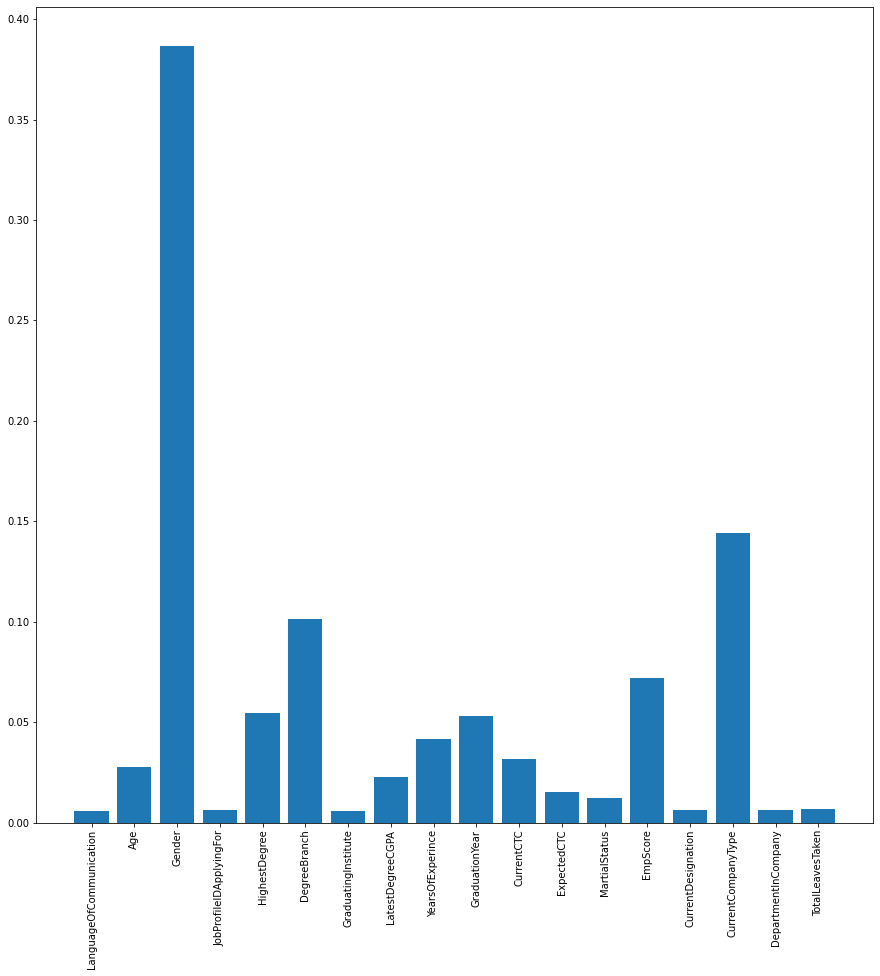

Fold 1
 rows of train = 7834 rows of holdout = 1959
[0]	validation_0-merror:0.489025
Will train until validation_0-merror hasn't improved in 50 rounds.
[100]	validation_0-merror:0.12098
[200]	validation_0-merror:0.107708
Stopping. Best iteration:
[210]	validation_0-merror:0.105666

XGB Val OOF AUC= 0.9859285456894794
####################################################################################################
Fold 2
 rows of train = 7834 rows of holdout = 1959
[0]	validation_0-merror:0.49413
Will train until validation_0-merror hasn't improved in 50 rounds.
[100]	validation_0-merror:0.128127
[200]	validation_0-merror:0.114344
Stopping. Best iteration:
[178]	validation_0-merror:0.11026

XGB Val OOF AUC= 0.9864701497536961
####################################################################################################
Fold 3
 rows of train = 7834 rows of holdout = 1959
[0]	validation_0-merror:0.493109
Will train until validation_0-merror hasn't improved in 50 rounds.
[100]	val

In [ ]:
##XGBM

probs_xgb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=5, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = xgb.XGBClassifier(n_estimators=1000,
                                max_depth=6,
                                learning_rate=0.04,
                                subsample=0.9,
                                colsample_bytree=0.35,
                                objective = 'multi:softmax',
                                random_state = 1
                               )        


        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['merror'],
                    early_stopping_rounds=50)
        
        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])
        
        probs_xgb +=clf.predict_proba(test_df)[:,1]

        roc = roc_auc_score(to_categorical(y_train_cv.iloc[idxV]),probs_oof,multi_class='ovr')

        scores.append(roc)
        
        avg_loss.append(clf.best_score)

        print ('XGB Val OOF AUC=',roc)

        print('#'*100)

        if i==0:
            
            feature_importance(clf,X_train_cv)
            
print("Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.6f (%.6f)' % (np.array(scores).mean(), np.array(scores).std()))

In [ ]:
#Catboost
probs_cb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=5, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = CatBoostClassifier(iterations=10000,
                                learning_rate=0.01,
                                random_strength=0.1,
                                depth=8,
                                loss_function='MultiClass',
                                eval_metric='MultiClass',
                                leaf_estimation_method='Newton',
                                random_state = 1,
                                cat_features =cat_features,
                                rsm = 0.8
                                )    

        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT],
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                   early_stopping_rounds=60,verbose = 100)

        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])
        
        probs_cb +=clf.predict_proba(test_df)[:,1]
        
        roc = roc_auc_score(to_categorical(y_train_cv.iloc[idxV]),probs_oof,multi_class='ovr')

        scores.append(roc)

        print ('CatBoost Val OOF AUC=',roc)

        avg_loss.append(clf.best_score_['validation']['MultiClass'])

        if i==0:
            
            feature_importance(clf,X_train_cv)

        print('#'*100)

print("Log Loss Stats {0:.8f},{1:.8f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.8f (%.8f)' % (np.array(scores).mean(), np.array(scores).std()))